In [19]:
import os
import re
import string
import warnings
from collections import Counter

In [20]:
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

In [23]:
import pytesseract
import gradio as gr
from tqdm.auto import tqdm
tqdm.pandas()


In [24]:
DATA_FILES = {
    "reddit": "depression_dataset_reddit_cleaned.csv",  # expects 'clean_text', 'is_depression'
    "twitter": "Twitter_Data.csv"  # try several possible names
}
RANDOM_STATE = 42

In [25]:
import nltk
import os

# Create local nltk_data directory if missing
NLTK_DATA_DIR = os.path.join(os.path.expanduser("~"), "nltk_data")
os.makedirs(NLTK_DATA_DIR, exist_ok=True)
nltk.data.path.append(NLTK_DATA_DIR)

# Auto-download all required resources
required_packages = [
    "punkt",          # Tokenizer
    "punkt_tab",      # Needed for newer NLTK versions
    "stopwords",      # Stopword lists
    "wordnet",        # Lemmatizer dictionary
    "omw-1.4"         # WordNet language mappings
]

for pkg in required_packages:
    try:
        nltk.data.find(f"tokenizers/{pkg}" if "punkt" in pkg else f"corpora/{pkg}")
    except LookupError:
        print(f"[INFO] Downloading missing NLTK resource: {pkg}")
        nltk.download(pkg, download_dir=NLTK_DATA_DIR)


[INFO] Downloading missing NLTK resource: wordnet
[INFO] Downloading missing NLTK resource: omw-1.4


[nltk_data] Downloading package wordnet to C:\Users\Asus\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Asus\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
import pandas as pd

df = pd.read_csv("Twitter_Data.csv")
print("Columns:", df.columns.tolist())
print(df.head())
print(df['sentiment'].unique() if 'sentiment' in df.columns else "No 'sentiment' column found.")


Columns: ['clean_text', 'category']
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
No 'sentiment' column found.


[INFO] Starting training/evaluation pipeline (if datasets present). This may take some minutes on large data.

[Twitter] Preprocessing text...


100%|██████████| 90723/90723 [00:35<00:00, 2535.93it/s]



--- EDA for Twitter ---
Rows: 90723
sentiment
1    55213
0    35510
Name: count, dtype: int64

Sample (first 3):
['modi promised minimum government maximum governance expected begin difficult job reforming state take year get justice state business exit psus temple', 'talk nonsense continue drama vote modi', 'kiya tho refresh maarkefir comment karo']


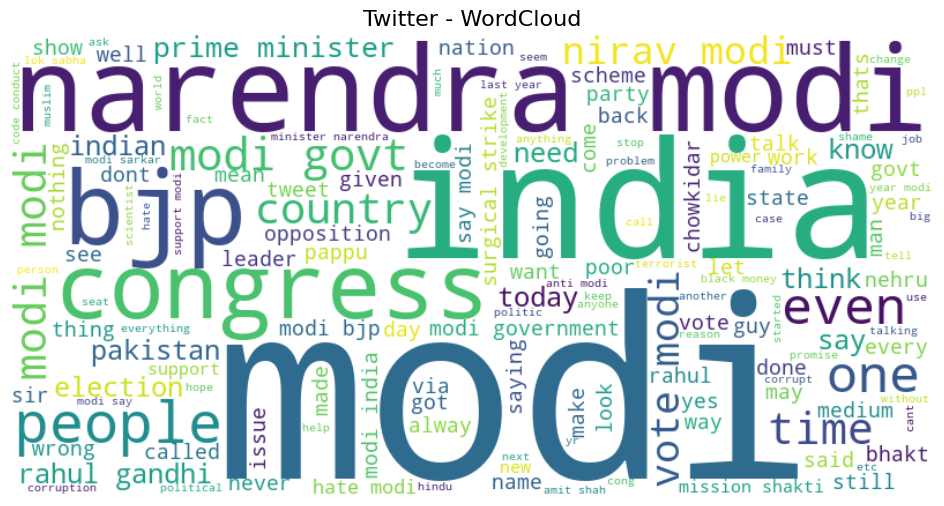

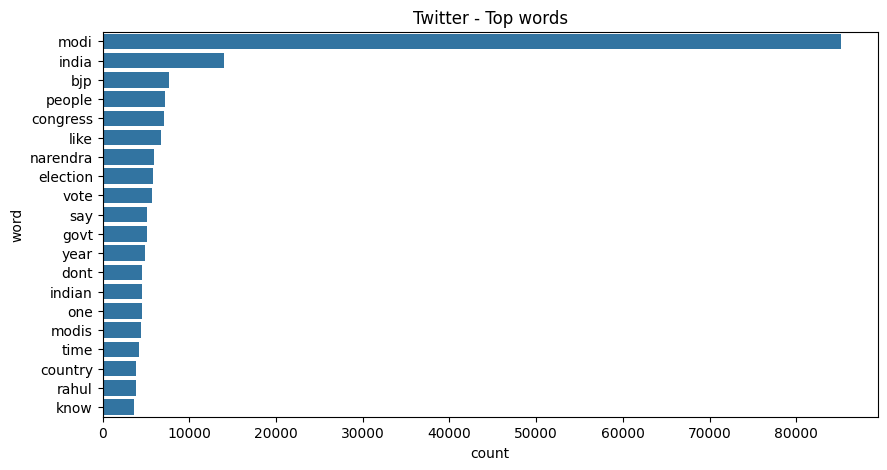


[Twitter] Training pipeline...

[Twitter] Evaluation:

Accuracy: 0.9131992284375862

Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.83      0.88      7102
    Positive       0.90      0.97      0.93     11043

    accuracy                           0.91     18145
   macro avg       0.92      0.90      0.91     18145
weighted avg       0.92      0.91      0.91     18145



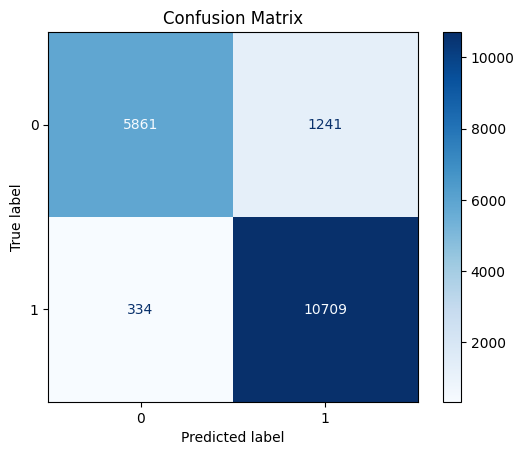

ROC-AUC: 0.9663488975649399


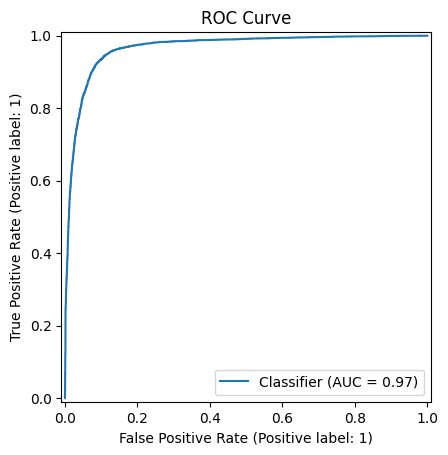

[info] Saved twitter_sentiment_pipeline.joblib

[Reddit] Preprocessing text...


100%|██████████| 7731/7731 [00:07<00:00, 1017.56it/s]



--- EDA for Reddit ---
Rows: 7731
is_depression
0    3900
1    3831
Name: count, dtype: int64

Sample (first 3):
['understand people reply immediately op invitation talk privately mean help type response usually lead either disappointment disaster usually work quite differently say pm anytime casual social context huge admiration appreciation goodwill good citizenship many support others flag inappropriate content even know many struggling hard work behind scene information resource make easier give get quality help small start new wiki page explains detail much better respond public comment least gotten know someone maintained depression wiki private contact full text current version summary anyone acting helper invite accepts private contact pm chat kind offsite communication early conversion showing either bad intention bad judgement either way unwise trust pm anytime seems like kind generous offer might perfectly well meaning unless solid rapport ha established wise idea point con

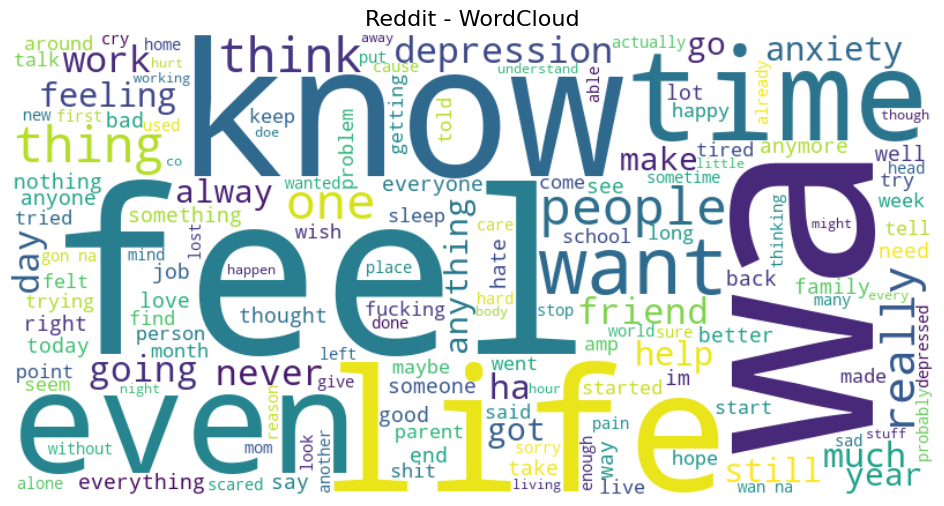

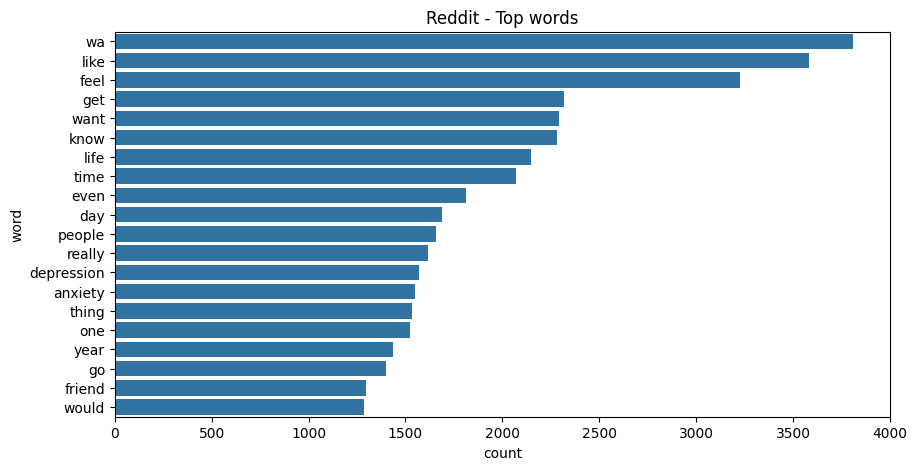


[Reddit] Training pipeline...

[Reddit] Evaluation:

Accuracy: 0.9592760180995475

Classification Report:
                 precision    recall  f1-score   support

Not Depression       0.94      0.98      0.96       780
    Depression       0.98      0.94      0.96       767

      accuracy                           0.96      1547
     macro avg       0.96      0.96      0.96      1547
  weighted avg       0.96      0.96      0.96      1547



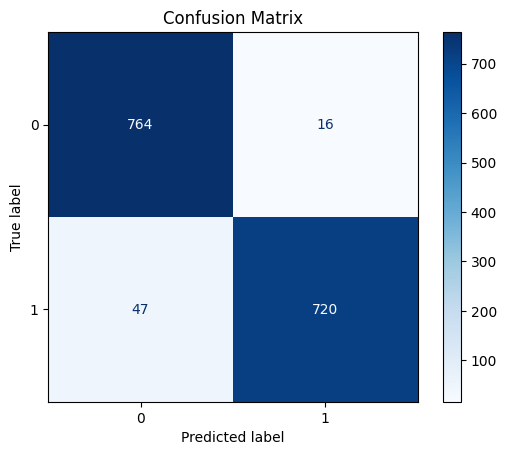

ROC-AUC: 0.992438070404172


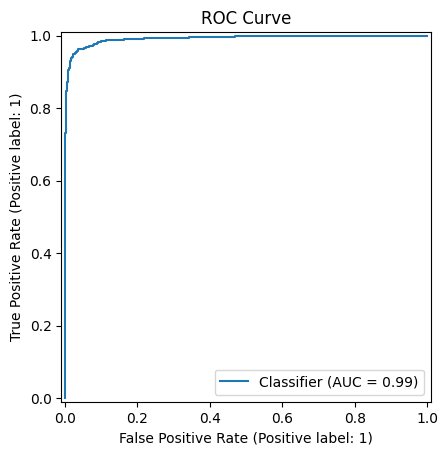

[info] Saved reddit_depression_pipeline.joblib

[INFO] Pipelines ready. twitter_pipeline: True reddit_pipeline: True

[INFO] Launching Gradio UI. Open the local link printed below (or set share=True in launch_gradio).
* Running on local URL:  http://0.0.0.0:7860
* To create a public link, set `share=True` in `launch()`.


In [27]:



CONTRACTION_MAP = {
    "aren't": "are not", "can't": "can not", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he's": "he is", "she's": "she is", "it's": "it is",
    "i'm": "i am", "isn't": "is not", "let's": "let us", "mustn't": "must not",
    "shan't": "shall not", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they're": "they are", "we're": "we are", "won't": "will not",
    "wouldn't": "would not", "you're": "you are", "you've": "you have", "we've": "we have",
    "i've": "i have", "i'd": "i would", "you'd": "you would"
}

EMOJI_PATTERN = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)


def expand_contractions(text):
    # simple contraction expansion
    for contr, expanded in CONTRACTION_MAP.items():
        text = re.sub(r"\b" + re.escape(contr) + r"\b", expanded, text)
    return text


def remove_urls_mentions_hashtags(text):
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)  # mentions
    # optionally keep hashtags but remove # char
    text = re.sub(r"#(\w+)", r"\1", text)
    return text


def remove_emoji(text):
    return EMOJI_PATTERN.sub(r'', text)


lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))


def preprocess_text(text, extra_stopwords=None):
    """Robust preprocessing: lower, expand contractions, remove urls/mentions, punctuation, stopwords, lemmatize."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = expand_contractions(text)
    text = remove_urls_mentions_hashtags(text)
    text = remove_emoji(text)
    # remove punctuation and numbers (keep spaces)
    text = re.sub(r"[^a-z\s]", " ", text)
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords and single-letter tokens
    stopset = STOPWORDS.copy()
    if extra_stopwords:
        stopset.update(extra_stopwords)
    tokens = [t for t in tokens if t not in stopset and len(t) > 1]
    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


def find_existing_twitter_file():
    """
    Returns the path to the Twitter dataset if it exists and is a valid file.
    """
    tpath = DATA_FILES["twitter"]
    if os.path.exists(tpath) and os.path.isfile(tpath):
        return tpath
    return None


def load_datasets():
    reddit_df = None
    twitter_df = None

    # --- Reddit ---
    rpath = DATA_FILES["reddit"]
    if os.path.exists(rpath) and os.path.isfile(rpath):
        reddit_df = pd.read_csv(rpath)
        if 'clean_text' not in reddit_df.columns and 'text' in reddit_df.columns:
            reddit_df = reddit_df.rename(columns={'text': 'clean_text'})
        if 'is_depression' not in reddit_df.columns:
            warnings.warn("Reddit dataset does not contain 'is_depression' column; skipping reddit modeling.")
            reddit_df = None
    else:
        print(f"[INFO] Reddit file not found at {rpath} — reddit modeling will be skipped.")

    # --- Twitter ---
  
    # --- Twitter ---
    tpath = find_existing_twitter_file()
    if tpath:
        twitter_df = pd.read_csv(tpath)

        # Normalize column names
        if 'text' not in twitter_df.columns:
            if 'tweet' in twitter_df.columns:
                twitter_df = twitter_df.rename(columns={'tweet': 'text'})
            elif 'clean_text' in twitter_df.columns:
                twitter_df = twitter_df.rename(columns={'clean_text': 'text'})

        if 'sentiment' not in twitter_df.columns:
            if 'category' in twitter_df.columns:
                twitter_df = twitter_df.rename(columns={'category': 'sentiment'})
            else:
                warnings.warn("Twitter dataset does not contain 'sentiment' column; skipping twitter modeling.")
                twitter_df = None

        # --- Fix label encoding ---
        if twitter_df is not None:
            # Drop NaN/inf values first
            twitter_df = twitter_df[pd.to_numeric(twitter_df['sentiment'], errors='coerce').notna()]

            # Convert to float safely
            twitter_df['sentiment'] = twitter_df['sentiment'].astype(float)

            # Map -1 → 0, 0 → 1
            twitter_df['sentiment'] = twitter_df['sentiment'].map({-1.0: 0, 0.0: 1})

            # Drop rows that don't fit mapping (e.g., NaN after mapping)
            twitter_df = twitter_df.dropna(subset=['sentiment'])

            # Ensure int type
            twitter_df['sentiment'] = twitter_df['sentiment'].astype(int)
    else:
        print(f"[INFO] Twitter file not found at {DATA_FILES['twitter']} — twitter modeling will be skipped.")

    return reddit_df, twitter_df



def quick_eda(df, text_col, label_col=None, name="dataset"):
    print(f"\n--- EDA for {name} ---")
    print("Rows:", len(df))
    if label_col and label_col in df.columns:
        print(df[label_col].value_counts(dropna=False))
    # sample texts
    print("\nSample (first 3):")
    print(df[text_col].head(3).tolist())


def plot_wordcloud(text_series, title="WordCloud", max_words=150):
    text = " ".join(t for t in text_series.astype(str))
    if not text.strip():
        print("[info] No text to render WordCloud.")
        return
    wc = WordCloud(width=800, height=400, background_color="white", max_words=max_words)
    wc.generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


def plot_top_n_words(series, n=20, title="Top words"):
    words = " ".join(series.astype(str)).split()
    cnt = Counter(words)
    most = cnt.most_common(n)
    if not most:
        print("[info] No words to show.")
        return
    df = pd.DataFrame(most, columns=['word', 'count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='word', data=df)
    plt.title(title)
    plt.show()


# --- Model training pipeline ---


def build_and_train_pipeline(X_train, y_train, do_gridsearch=False):
    """Return fitted pipeline (TfidfVectorizer + LogisticRegression)"""
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=3)),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ])
    if do_gridsearch:
        param_grid = {
            "tfidf__min_df": [2, 3, 5],
            "clf__C": [0.1, 1, 5]
        }
        grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        print("Best params:", grid.best_params_)
        return grid.best_estimator_
    else:
        pipe.fit(X_train, y_train)
        return pipe


def evaluate_model(pipe, X_test, y_test, target_names=None, plot_roc=True):
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
        else:
            # pipeline's final estimator may have predict_proba
            y_proba = pipe.named_steps['clf'].predict_proba(pipe.named_steps['tfidf'].transform(X_test))[:, 1]
    except Exception:
        y_proba = None

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    if y_proba is not None and plot_roc:
        try:
            roc_auc = roc_auc_score(y_test, y_proba)
            print("ROC-AUC:", roc_auc)
            RocCurveDisplay.from_predictions(y_test, y_proba)
            plt.title("ROC Curve")
            plt.show()
        except Exception:
            pass


# --- OCR helpers ---


def extract_text_from_image(image_input):
    """
    Accepts:
      - PIL.Image.Image
      - path to image
      - bytes buffer (PIL will handle)
    Returns extracted raw text (string).
    """
    if isinstance(image_input, str) and os.path.exists(image_input):
        img = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        img = image_input
    else:
        # try to let PIL open it (gr.Image will pass PIL object normally)
        try:
            img = Image.open(image_input)
        except Exception as e:
            print("Could not open image for OCR:", e)
            return ""
    # optional: convert to grayscale, increase contrast, resize for better OCR
    try:
        gray = img.convert('L')
        # a small resize to improve OCR on tiny images
        w, h = gray.size
        if max(w, h) < 800:
            scale = 800 / max(w, h)
            gray = gray.resize((int(w * scale), int(h * scale)))
        text = pytesseract.image_to_string(gray, lang='eng')
    except Exception as e:
        print("pytesseract error:", e)
        text = ""
    return text


# --- Main workflow: attempt to load, preprocess, train and evaluate ---


def main(train_with_gridsearch=False):
    reddit_df, twitter_df = load_datasets()

    twitter_pipeline = None
    reddit_pipeline = None

    # Train Twitter sentiment classifier (if dataset exists)
    if twitter_df is not None:
        # expect columns 'text' and 'sentiment' (0/1)
        if 'text' in twitter_df.columns and 'sentiment' in twitter_df.columns:
            print("\n[Twitter] Preprocessing text...")
            twitter_df['processed_text'] = twitter_df['text'].astype(str).progress_apply(preprocess_text)
            quick_eda(twitter_df, text_col='processed_text', label_col='sentiment', name='Twitter')
            plot_wordcloud(twitter_df['processed_text'], title="Twitter - WordCloud")
            plot_top_n_words(twitter_df['processed_text'], n=20, title="Twitter - Top words")
# Clean up NaN or non-numeric sentiment values
            twitter_df = twitter_df.dropna(subset=['sentiment'])
            twitter_df = twitter_df[twitter_df['sentiment'].astype(str).str.isnumeric()]
            twitter_df['sentiment'] = twitter_df['sentiment'].astype(int)

            X = twitter_df['processed_text']
            y = twitter_df['sentiment'].astype(int)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
            print("\n[Twitter] Training pipeline...")
            twitter_pipeline = build_and_train_pipeline(X_train, y_train, do_gridsearch=train_with_gridsearch)
            print("\n[Twitter] Evaluation:")
            evaluate_model(twitter_pipeline, X_test, y_test, target_names=['Negative', 'Positive'])
            # save model
            try:
                import joblib
                joblib.dump(twitter_pipeline, "twitter_sentiment_pipeline.joblib")
                print("[info] Saved twitter_sentiment_pipeline.joblib")
            except Exception:
                pass
        else:
            print("[info] Twitter dataset doesn't contain expected columns 'text' and 'sentiment'.")

    # Train Reddit depression classifier (if dataset exists)
    if reddit_df is not None:
        if 'clean_text' in reddit_df.columns and 'is_depression' in reddit_df.columns:
            print("\n[Reddit] Preprocessing text...")
            reddit_df['processed_text'] = reddit_df['clean_text'].astype(str).progress_apply(preprocess_text)
            quick_eda(reddit_df, text_col='processed_text', label_col='is_depression', name='Reddit')
            plot_wordcloud(reddit_df['processed_text'], title="Reddit - WordCloud")
            plot_top_n_words(reddit_df['processed_text'], n=20, title="Reddit - Top words")

            X = reddit_df['processed_text']
            y = reddit_df['is_depression'].astype(int)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
            print("\n[Reddit] Training pipeline...")
            reddit_pipeline = build_and_train_pipeline(X_train, y_train, do_gridsearch=train_with_gridsearch)
            print("\n[Reddit] Evaluation:")
            evaluate_model(reddit_pipeline, X_test, y_test, target_names=['Not Depression', 'Depression'])
            try:
                import joblib
                joblib.dump(reddit_pipeline, "reddit_depression_pipeline.joblib")
                print("[info] Saved reddit_depression_pipeline.joblib")
            except Exception:
                pass
        else:
            print("[info] Reddit dataset doesn't contain expected columns 'clean_text' and 'is_depression'.")

    # If models were not trained above but saved joblib exist, try loading them
    if twitter_pipeline is None and os.path.exists("twitter_sentiment_pipeline.joblib"):
        try:
            import joblib
            twitter_pipeline = joblib.load("twitter_sentiment_pipeline.joblib")
            print("[info] Loaded saved twitter_sentiment_pipeline.joblib")
        except Exception:
            pass
    if reddit_pipeline is None and os.path.exists("reddit_depression_pipeline.joblib"):
        try:
            import joblib
            reddit_pipeline = joblib.load("reddit_depression_pipeline.joblib")
            print("[info] Loaded saved reddit_depression_pipeline.joblib")
        except Exception:
            pass

    print("\n[INFO] Pipelines ready. twitter_pipeline:", bool(twitter_pipeline),
          "reddit_pipeline:", bool(reddit_pipeline))
    return twitter_pipeline, reddit_pipeline


# --- Analysis functions (used by the UI) ---


def analyze_text_with_pipeline(text, pipeline, model_name="model"):
    if pipeline is None:
        return f"No {model_name} available (not trained or loaded)."
    processed = preprocess_text(text)
    pred = pipeline.predict([processed])[0]
    try:
        proba = pipeline.predict_proba([processed])[0].max()
        return {"prediction": int(pred), "probability": float(proba), "processed_text": processed}
    except Exception:
        return {"prediction": int(pred), "processed_text": processed}


def analyze_image_and_text(image, pipeline, model_name="model"):
    raw_text = extract_text_from_image(image)
    if not raw_text.strip():
        return {"raw_text": "", "message": "No text found in image."}
    result = analyze_text_with_pipeline(raw_text, pipeline, model_name=model_name)
    # Format output
    if isinstance(result, dict):
        return {"raw_text": raw_text, **result}
    else:
        return {"raw_text": raw_text, "message": str(result)}


# --- Gradio Interface ---


def launch_gradio(twitter_pipeline, reddit_pipeline):
    """
    Gradio UI with:
    - Text box to paste text for sentiment + depression analysis
    - Image upload to OCR -> analyze
    - Toggle which model to use: Twitter sentiment or Reddit depression
    """
    def predict_text(input_text, model_choice):
        if not input_text or str(input_text).strip() == "":
            return "Please provide text or upload an image containing text."
        if model_choice == "Twitter Sentiment":
            res = analyze_text_with_pipeline(input_text, twitter_pipeline, model_name="Twitter sentiment")
            if isinstance(res, dict):
                return f"Prediction: {res.get('prediction')} (0=Neg,1=Pos), Prob: {res.get('probability', 'N/A'):.3f}\nProcessed text:\n{res.get('processed_text')}"
            else:
                return str(res)
        else:
            res = analyze_text_with_pipeline(input_text, reddit_pipeline, model_name="Reddit depression")
            if isinstance(res, dict):
                return f"Prediction: {res.get('prediction')} (0=Not depression,1=Depression), Prob: {res.get('probability', 'N/A'):.3f}\nProcessed text:\n{res.get('processed_text')}"
            else:
                return str(res)

    def predict_image(image, model_choice):
        if image is None:
            return "Please upload an image."
        pipeline = twitter_pipeline if model_choice == "Twitter Sentiment" else reddit_pipeline
        result = analyze_image_and_text(image, pipeline, model_name=model_choice)
        # create readable message
        if "message" in result:
            return result.get("message") + ("\nDetected raw text:\n" + result.get("raw_text", "") if result.get("raw_text") else "")
        else:
            if "probability" in result:
                prob = f"{result['probability']:.3f}"
            else:
                prob = "N/A"
            pred = result.get("prediction", "N/A")
            return f"Prediction: {pred}, Prob: {prob}\nDetected raw text:\n{result.get('raw_text', '')}\nProcessed:\n{result.get('processed_text','')}"
    
    title = "Text & Image Sentiment / Depression Analyzer (OCR)"
    description = "Upload an image (contains text) or paste text. Choose model: Twitter Sentiment or Reddit Depression. Note: 'Twitter Sentiment' expects sentiment labels (0/1). 'Reddit Depression' expects depression labels (0/1)."

    with gr.Blocks() as demo:
        gr.Markdown(f"# {title}")
        gr.Markdown(description)
        with gr.Row():
            with gr.Column(scale=1):
                model_choice = gr.Radio(["Twitter Sentiment", "Reddit Depression"], value="Twitter Sentiment", label="Select model")
                input_text = gr.Textbox(lines=6, placeholder="Paste text here to analyze...", label="Text input")
                text_button = gr.Button("Analyze Text")
                text_output = gr.Textbox(label="Result (text)", lines=6)
            with gr.Column(scale=1):
                img_input = gr.Image(type="pil", label="Upload image containing text")
                img_button = gr.Button("Analyze Image (OCR)")
                img_output = gr.Textbox(label="Result (image)", lines=6)
        text_button.click(fn=predict_text, inputs=[input_text, model_choice], outputs=[text_output])
        img_button.click(fn=predict_image, inputs=[img_input, model_choice], outputs=[img_output])

    demo.launch(server_name="0.0.0.0", share=False)


# --- Run script ---


if __name__ == "__main__":
    print("[INFO] Starting training/evaluation pipeline (if datasets present). This may take some minutes on large data.")
    twitter_pipeline, reddit_pipeline = main(train_with_gridsearch=False)
    print("\n[INFO] Launching Gradio UI. Open the local link printed below (or set share=True in launch_gradio).")
    launch_gradio(twitter_pipeline, reddit_pipeline)